In [90]:
import opendatasets as od

od.download(
	"https://www.kaggle.com/datasets/andrewmvd/car-plate-detection")


100%|██████████| 203M/203M [00:22<00:00, 9.30MB/s] 


In [89]:
import splitfolders

In [91]:
data_path='car-plate-detection'

In [92]:
splitfolders.ratio(data_path,output='splitted_data',seed=1,ratio=(0.8,0.1,0.1))

Copying files: 866 files [00:02, 331.39 files/s]


In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_images(img_path):
    byte_img=tf.io.read_file(img_path)
    img=tf.io.decode_png(byte_img,channels=3)
    return img

In [3]:
import xml.etree.ElementTree as ET

def extract_boxes(filename): 
    with open(filename.numpy(),'r',encoding='utf-8') as f:
        # load and parse the file
        tree = ET.parse(f)
        # get the root of the document
        root = tree.getroot()
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            coors=list(np.divide(coors,[width,height,width,height]))
            boxes.append(coors)
       
    return boxes

In [4]:
train_path=os.path.join('splitted_data','train')
test_path=os.path.join('splitted_data','test')
val_path=os.path.join('splitted_data','val')

In [47]:
train_images=tf.data.Dataset.list_files(os.path.join(train_path,'images','*.png'),shuffle=False)

In [48]:
a=train_images.as_numpy_iterator()

In [52]:
a.next()

b'splitted_data\\train\\images\\Cars102.png'

In [5]:
train_images=tf.data.Dataset.list_files(os.path.join(train_path,'images','*.png'),shuffle=False)
train_images=train_images.map(load_images)
train_images=train_images.map(lambda x:tf.image.resize(x,(120,120)))
train_images=train_images.map(lambda x:x/255)

In [6]:
test_images=tf.data.Dataset.list_files(os.path.join(test_path,'images','*.png'),shuffle=False)
test_images=test_images.map(load_images)
test_images=test_images.map(lambda x:tf.image.resize(x,(120,120)))
test_images=test_images.map(lambda x:x/255)

In [7]:
val_images=tf.data.Dataset.list_files(os.path.join(val_path,'images','*.png'),shuffle=False)
val_images=val_images.map(load_images)
val_images=val_images.map(lambda x:tf.image.resize(x,(120,120)))
val_images=val_images.map(lambda x:x/255)

In [6]:
train_images.as_numpy_iterator().next()

array([[[0.22171023, 0.48258716, 0.598268  ],
        [0.28161764, 0.50083333, 0.60075164],
        [0.42873093, 0.4742811 , 0.49740744],
        ...,
        [0.09703124, 0.1014649 , 0.09884512],
        [0.1732191 , 0.17517965, 0.17344783],
        [0.13903578, 0.14537564, 0.14596389]],

       [[0.23207517, 0.4712582 , 0.5625    ],
        [0.3147549 , 0.49279413, 0.56627446],
        [0.31382352, 0.36550653, 0.3862418 ],
        ...,
        [0.09679554, 0.11403424, 0.0913384 ],
        [0.1553924 , 0.15455917, 0.1531368 ],
        [0.11872558, 0.13500008, 0.12931381]],

       [[0.28464052, 0.46753812, 0.5272876 ],
        [0.3232026 , 0.44215685, 0.4729575 ],
        [0.34575155, 0.3823801 , 0.38758162],
        ...,
        [0.21369915, 0.23720133, 0.22026281],
        [0.12630658, 0.1259799 , 0.13153473],
        [0.17499854, 0.1916652 , 0.23630032]],

       ...,

       [[0.29033202, 0.20013593, 0.16876338],
        [0.24901937, 0.1588233 , 0.12745073],
        [0.23368715, 0

In [27]:
type(train_images.as_numpy_iterator().next())

numpy.ndarray

In [8]:
train_labels=tf.data.Dataset.list_files(os.path.join(train_path,'labels','*.xml'),shuffle=False)
train_labels=train_labels.map(lambda x:tf.py_function(extract_boxes,[x],tf.float16))

In [9]:
test_labels=tf.data.Dataset.list_files(os.path.join(test_path,'labels','*.xml'),shuffle=False)
test_labels=test_labels.map(lambda x:tf.py_function(extract_boxes,[x],tf.float16))

In [10]:
val_labels=tf.data.Dataset.list_files(os.path.join(val_path,'labels','*.xml'),shuffle=False)
val_labels=val_labels.map(lambda x:tf.py_function(extract_boxes,[x],tf.float16))

In [229]:
train_labels=tf.data.Dataset.list_files(os.path.join(train_path,'labels','*.xml'),shuffle=False)
train_labels=train_labels.map(lambda x:tf.py_function(extract_boxes,[x],tf.float16))

In [32]:
a=train_labels.as_numpy_iterator()

In [35]:
b=a.next()
b

array([0.4375, 0.427 , 0.535 , 0.4907], dtype=float16)

In [11]:
train=tf.data.Dataset.zip((train_images,train_labels))
train=train.shuffle(800)
train=train.batch(8)
train=train.prefetch(4)

In [12]:
val=tf.data.Dataset.zip((val_images,val_labels))
val=val.shuffle(100)
val=val.batch(8)
val=val.prefetch(4)

In [13]:
test=tf.data.Dataset.zip((test_images,test_labels))
test=test.shuffle(100)
test=test.batch(8)
test=test.prefetch(4)

In [46]:
x,y=train.as_numpy_iterator().next()

In [47]:
x.shape

(8, 120, 120, 3)

In [51]:
y.shape

(8, 4)

In [49]:
len(train_images),len(train_labels)

(346, 346)

In [19]:
len(test_images),len(test_labels)

(44, 44)

In [20]:
len(val_images),len(val_labels)

(43, 43)

In [2]:
import cv2

In [40]:
sample=train.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.135 0.809 0.22  0.854]
[0.2275 0.752  0.4924 0.8823]
[0.775  0.547  0.93   0.6406]
[0.475  0.3906 0.6426 0.51  ]


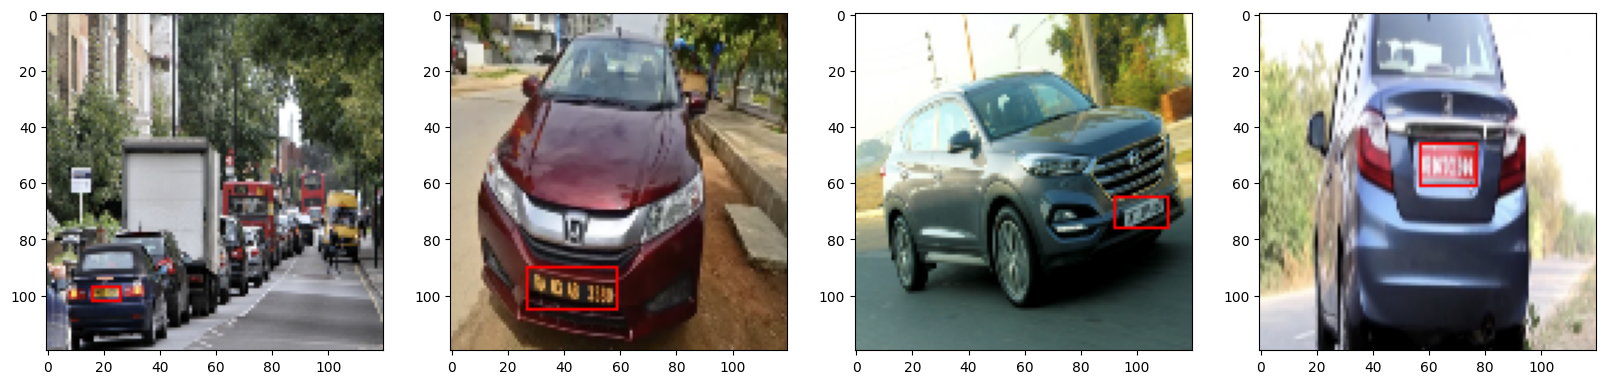

In [41]:
res=sample.next()

fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx in range(4):
    sample_img=res[0][idx]
    sample_coords=res[1][idx]
    print(sample_coords)
    #print(sample_coords)
    cv2.rectangle(sample_img,
                  tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:],[120,120]).astype(int)),
                  (250,0,0),1)
    ax[idx].imshow(sample_img)

In [3]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,BatchNormalization,Dropout,LeakyReLU
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.applications.resnet_v2 import ResNet50V2

In [17]:
conv_base=VGG16(weights='imagenet',include_top=False,input_shape=(120,120,3))

In [18]:
model=Sequential()

model.add(conv_base)
model.add(Flatten())

model.add(Dense(2048,activation=LeakyReLU(0.001)))
model.add(Dense(2048,activation=LeakyReLU(0.001)))

model.add(Dense(4,activation='sigmoid'))

In [49]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 4608)              0         
                                                                 
 dense_90 (Dense)            (None, 2048)              9439232   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_91 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_92 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_93 (Dense)            (None, 2048)             

In [19]:
model.compile(optimizer=Adam(learning_rate=0.000005),loss=tf.keras.losses.MeanSquaredError())

In [31]:
history=model.fit(train,epochs=10,validation_data=val)

Epoch 1/10
44/44 [==============================] - 69s 2s/step - loss: 0.0013 - val_loss: 0.0149
Epoch 2/10
44/44 [==============================] - 67s 2s/step - loss: 0.0013 - val_loss: 0.0151
Epoch 3/10
44/44 [==============================] - 68s 2s/step - loss: 0.0013 - val_loss: 0.0149
Epoch 4/10
44/44 [==============================] - 68s 2s/step - loss: 0.0011 - val_loss: 0.0147
Epoch 5/10
44/44 [==============================] - 68s 2s/step - loss: 0.0012 - val_loss: 0.0154
Epoch 6/10
44/44 [==============================] - 68s 2s/step - loss: 0.0012 - val_loss: 0.0151
Epoch 7/10
44/44 [==============================] - 73s 2s/step - loss: 0.0011 - val_loss: 0.0151
Epoch 8/10
44/44 [==============================] - 70s 2s/step - loss: 0.0012 - val_loss: 0.0149
Epoch 9/10
44/44 [==============================] - 70s 2s/step - loss: 0.0012 - val_loss: 0.0152
Epoch 10/10
44/44 [==============================] - 70s 2s/step - loss: 0.0012 - val_loss: 0.0148


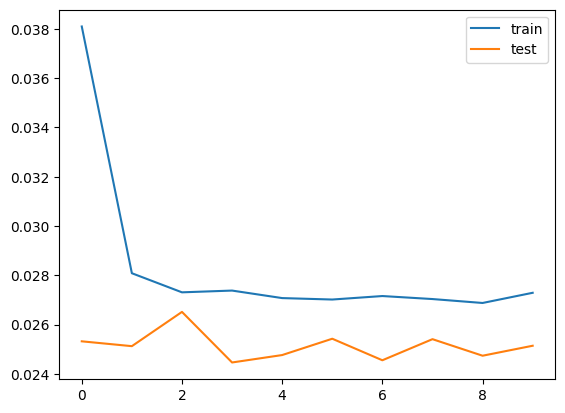

In [22]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

In [27]:
test_sample=test.as_numpy_iterator()
sample=test_sample.next()

In [22]:
sample[1].shape

(8, 4)

In [28]:
ypred=model.predict(sample[0])

1/1 [==============================] - 0s 336ms/step


In [29]:
ypred

array([[0.12354046, 0.43721732, 0.51010275, 0.8084066 ],
       [0.47198996, 0.6855877 , 0.44580472, 0.76586884],
       [0.11392282, 0.26847982, 0.24815096, 0.3392963 ],
       [0.254715  , 0.6253361 , 0.35322177, 0.7289979 ],
       [0.44897488, 0.5558868 , 0.61295426, 0.72059697],
       [0.5579826 , 0.56063044, 0.7470386 , 0.7468062 ],
       [0.24150567, 0.24337512, 0.91749114, 0.57563794],
       [0.33767343, 0.51171917, 0.6672835 , 0.60698754]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.12354046 0.43721732 0.51010275 0.8084066 ]
[0.47198996 0.6855877  0.44580472 0.76586884]
[0.11392282 0.26847982 0.24815096 0.3392963 ]
[0.254715   0.6253361  0.35322177 0.7289979 ]


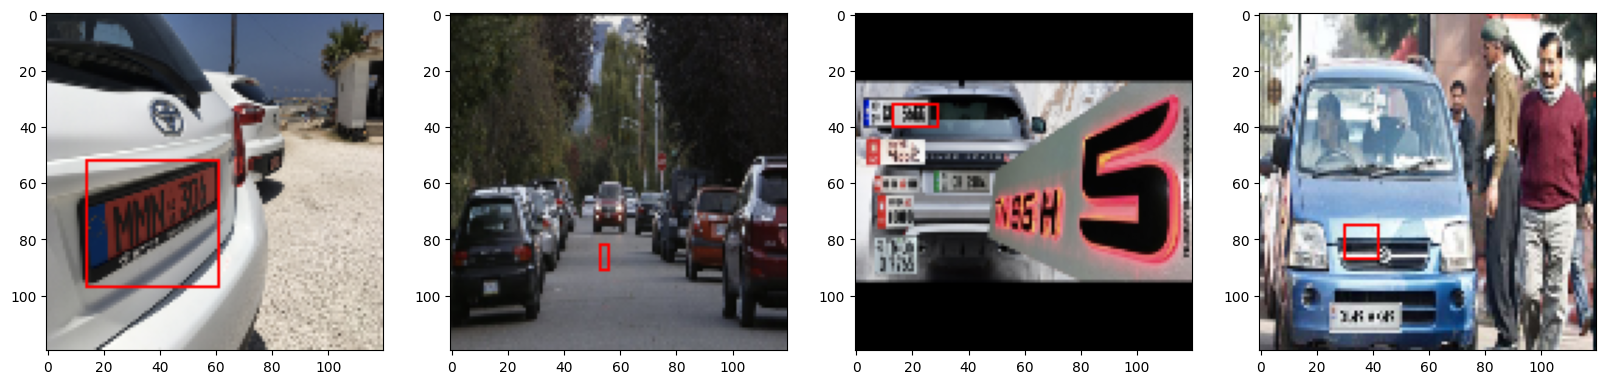

In [30]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx in range(4):
    sample_img=sample[0][idx]

    sample_coords=ypred[idx]
    print(sample_coords)
    cv2.rectangle(sample_img,
                  tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:],[120,120]).astype(int)),
                  (250,0,0),1)
    ax[idx].imshow(sample_img)

In [ ]:
model.save('licenseplatemodel.h5')

In [4]:
from keras.models import load_model

In [5]:
model=load_model('licenseplatemodel.h5')

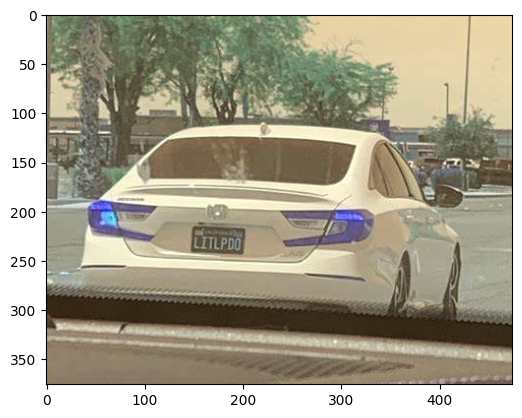

In [6]:
img=cv2.imread('google.jpg')
plt.imshow(img)
plt.show()

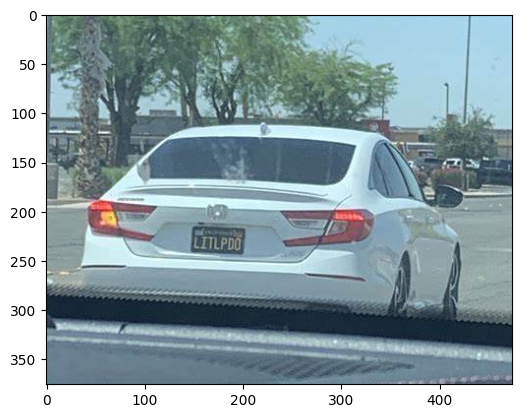

In [7]:
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [8]:
img=cv2.resize(img,(120,120))
img.shape

(120, 120, 3)

In [9]:
img

array([[[126, 149, 152],
        [102, 128, 127],
        [120, 154, 123],
        ...,
        [172, 217, 240],
        [171, 217, 240],
        [175, 221, 244]],

       [[120, 144, 147],
        [101, 127, 127],
        [104, 138, 108],
        ...,
        [168, 214, 237],
        [168, 214, 237],
        [170, 216, 239]],

       [[118, 142, 145],
        [119, 145, 144],
        [113, 146, 116],
        ...,
        [167, 213, 236],
        [167, 214, 236],
        [171, 217, 240]],

       ...,

       [[100, 128, 142],
        [101, 126, 142],
        [102, 124, 140],
        ...,
        [125, 136, 153],
        [127, 137, 154],
        [141, 151, 168]],

       [[ 99, 128, 141],
        [100, 127, 141],
        [103, 125, 141],
        ...,
        [103, 112, 130],
        [129, 136, 154],
        [133, 140, 158]],

       [[ 99, 128, 141],
        [100, 127, 141],
        [100, 123, 139],
        ...,
        [ 93, 102, 120],
        [ 87,  94, 112],
        [ 92,  99, 117]]

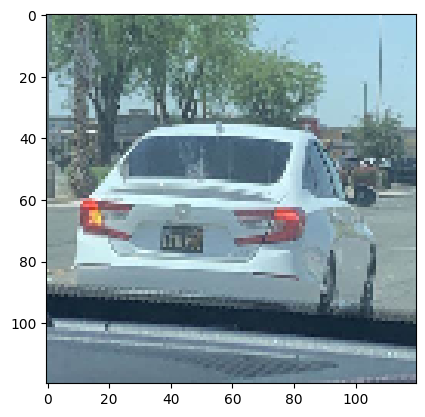

In [10]:
a=img/255
plt.imshow(a)

In [11]:
c=np.expand_dims(img,0)
c.shape

(1, 120, 120, 3)

In [12]:
g=model.predict(np.expand_dims(a,0))

1/1 [==============================] - 0s 475ms/step


In [13]:
g

array([[0.40653157, 0.5530744 , 0.55819684, 0.5925153 ]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.40653157 0.5530744  0.55819684 0.5925153 ]


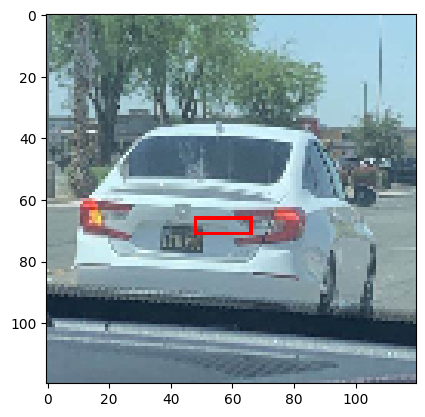

In [15]:
sample_coords=g[0]
print(sample_coords)
cv2.rectangle(a,
              tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),
              tuple(np.multiply(sample_coords[2:],[120,120]).astype(int)),
              (250,0,0),1)
plt.imshow(a)
plt.show()